In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import numpy as np
import cv2
import pandas as pd
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, classification_report

In [2]:
def preprocess_image(img, target_size=(224, 224)):
    """
    Preprocess the image:
      - Resize to target size.
      - Remove hair using morphological operations.
      - Normalize pixel values.
    """
    # Resize image
    img = cv2.resize(img, target_size)

    # Ensure img is uint8
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    # Hair removal: convert to grayscale and perform morphological closing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

    # Create mask for dark hair and ensure it's uint8
    mask = cv2.threshold(closed, 10, 255, cv2.THRESH_BINARY_INV)[1].astype(np.uint8)

    # Inpaint (ensure img is uint8)
    inpainted = cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA)

    # Normalize pixel values to [0,1]
    norm_img = inpainted.astype("float32") / 255.0
    return norm_img 

In [3]:
ROOT_DIR = "/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized"
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-4
CHECKPOINT_PATH = "/kaggle/working/best_model.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preprocessing
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomVerticalFlip(),    # Vertical flip
    transforms.RandomRotation(20),      # Random rotation by up to 20 degrees
    transforms.RandomAffine(degrees=0, shear=10),  # Shear transformation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color changes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = datasets.ImageFolder(ROOT_DIR, transform=transform)
num_classes = len(dataset.classes)
print(num_classes)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size  # Use the remaining as validation (test) set
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ----------------------------
# Load ViT Model
# ----------------------------
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ----------------------------
# Training & Evaluation
# ----------------------------
best_train_acc = 0
metrics = []

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    train_preds, train_labels = [], []
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            tepoch.set_postfix(loss=train_loss/total, accuracy=100.*correct/total)
    
    train_acc = 100. * correct / total
    avg_train_loss = train_loss / total
    
    # Save checkpoint if training accuracy improves
    if train_acc > best_train_acc:
        best_train_acc = train_acc
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print("Checkpoint saved!")
    
    # ----------------------------
    # Validation Step (using test set as validation)
    # ----------------------------
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_acc = 100. * val_correct / val_total
    
    # Compute additional metrics on training data
    train_precision = precision_score(train_labels, train_preds, average='weighted')
    train_recall = recall_score(train_labels, train_preds, average='weighted')
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    try:
        train_auc = roc_auc_score(np.eye(num_classes)[train_labels], np.eye(num_classes)[train_preds], multi_class='ovr')
    except Exception as e:
        train_auc = None
    
    # Compute metrics on validation data
    val_precision = precision_score(val_labels, val_preds, average='weighted')
    val_recall = recall_score(val_labels, val_preds, average='weighted')
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    try:
        val_auc = roc_auc_score(np.eye(num_classes)[val_labels], np.eye(num_classes)[val_preds], multi_class='ovr')
    except Exception as e:
        val_auc = None

    metrics.append([epoch+1, avg_train_loss, train_acc, train_precision, train_recall, train_f1, train_auc,
                    avg_val_loss, val_acc, val_precision, val_recall, val_f1, val_auc])
    
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Save metrics to CSV
columns = ["Epoch", "Train Loss", "Train Accuracy", "Train Precision", "Train Recall", "Train F1-Score", "Train AUC",
           "Val Loss", "Val Accuracy", "Val Precision", "Val Recall", "Val F1-Score", "Val AUC"]
metrics_df = pd.DataFrame(metrics, columns=columns)
metrics_df.to_csv("metrics.csv", index=False)
metrics_df.head()
print("Metrics saved to metrics.csv")

9


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 575/575 [15:54<00:00,  1.66s/batch, accuracy=73.3, loss=0.723]


Checkpoint saved!
Epoch 1: Train Loss: 0.7230, Train Acc: 73.29% | Val Loss: 0.5761, Val Acc: 77.70%


Epoch 2: 100%|██████████| 575/575 [14:29<00:00,  1.51s/batch, accuracy=81, loss=0.503]


Checkpoint saved!
Epoch 2: Train Loss: 0.5029, Train Acc: 80.99% | Val Loss: 0.5282, Val Acc: 80.23%


Epoch 3: 100%|██████████| 575/575 [14:32<00:00,  1.52s/batch, accuracy=83.7, loss=0.435]


Checkpoint saved!
Epoch 3: Train Loss: 0.4351, Train Acc: 83.73% | Val Loss: 0.4676, Val Acc: 81.47%


Epoch 4: 100%|██████████| 575/575 [14:33<00:00,  1.52s/batch, accuracy=85.4, loss=0.393]


Checkpoint saved!
Epoch 4: Train Loss: 0.3929, Train Acc: 85.37% | Val Loss: 0.4039, Val Acc: 84.73%


Epoch 5: 100%|██████████| 575/575 [14:36<00:00,  1.52s/batch, accuracy=86.1, loss=0.367]


Checkpoint saved!
Epoch 5: Train Loss: 0.3665, Train Acc: 86.12% | Val Loss: 0.5506, Val Acc: 81.05%


Epoch 6: 100%|██████████| 575/575 [14:31<00:00,  1.52s/batch, accuracy=86.8, loss=0.351]


Checkpoint saved!
Epoch 6: Train Loss: 0.3515, Train Acc: 86.82% | Val Loss: 0.4209, Val Acc: 84.12%


Epoch 7: 100%|██████████| 575/575 [14:32<00:00,  1.52s/batch, accuracy=87, loss=0.34]


Checkpoint saved!
Epoch 7: Train Loss: 0.3399, Train Acc: 87.04% | Val Loss: 0.4218, Val Acc: 84.58%


Epoch 8: 100%|██████████| 575/575 [14:33<00:00,  1.52s/batch, accuracy=87.7, loss=0.328]


Checkpoint saved!
Epoch 8: Train Loss: 0.3280, Train Acc: 87.71% | Val Loss: 0.3949, Val Acc: 85.77%


Epoch 9: 100%|██████████| 575/575 [14:31<00:00,  1.52s/batch, accuracy=88.9, loss=0.294]


Checkpoint saved!
Epoch 9: Train Loss: 0.2935, Train Acc: 88.87% | Val Loss: 0.3959, Val Acc: 85.82%


Epoch 10: 100%|██████████| 575/575 [14:29<00:00,  1.51s/batch, accuracy=89.2, loss=0.284]


Checkpoint saved!
Epoch 10: Train Loss: 0.2843, Train Acc: 89.16% | Val Loss: 0.4057, Val Acc: 85.84%


Epoch 11: 100%|██████████| 575/575 [14:31<00:00,  1.52s/batch, accuracy=89.8, loss=0.267]


Checkpoint saved!
Epoch 11: Train Loss: 0.2667, Train Acc: 89.83% | Val Loss: 0.4513, Val Acc: 84.32%


Epoch 12: 100%|██████████| 575/575 [14:33<00:00,  1.52s/batch, accuracy=90.1, loss=0.265]


Checkpoint saved!
Epoch 12: Train Loss: 0.2653, Train Acc: 90.12% | Val Loss: 0.4113, Val Acc: 84.79%


Epoch 13: 100%|██████████| 575/575 [14:31<00:00,  1.51s/batch, accuracy=90.6, loss=0.247]


Checkpoint saved!
Epoch 13: Train Loss: 0.2471, Train Acc: 90.63% | Val Loss: 0.3682, Val Acc: 86.86%


Epoch 14: 100%|██████████| 575/575 [14:32<00:00,  1.52s/batch, accuracy=90.8, loss=0.24]


Checkpoint saved!
Epoch 14: Train Loss: 0.2396, Train Acc: 90.80% | Val Loss: 0.3939, Val Acc: 86.25%


Epoch 15: 100%|██████████| 575/575 [14:30<00:00,  1.51s/batch, accuracy=91.6, loss=0.223]


Checkpoint saved!
Epoch 15: Train Loss: 0.2233, Train Acc: 91.60% | Val Loss: 0.3930, Val Acc: 86.47%


Epoch 16: 100%|██████████| 575/575 [14:31<00:00,  1.51s/batch, accuracy=91.9, loss=0.217]


Checkpoint saved!
Epoch 16: Train Loss: 0.2174, Train Acc: 91.86% | Val Loss: 0.4128, Val Acc: 85.73%


Epoch 17: 100%|██████████| 575/575 [14:29<00:00,  1.51s/batch, accuracy=92.1, loss=0.205]


Checkpoint saved!
Epoch 17: Train Loss: 0.2051, Train Acc: 92.15% | Val Loss: 0.4091, Val Acc: 85.88%


Epoch 18: 100%|██████████| 575/575 [14:31<00:00,  1.52s/batch, accuracy=92.4, loss=0.197]


Checkpoint saved!
Epoch 18: Train Loss: 0.1969, Train Acc: 92.44% | Val Loss: 0.4030, Val Acc: 86.62%


Epoch 19: 100%|██████████| 575/575 [14:33<00:00,  1.52s/batch, accuracy=92.9, loss=0.189]


Checkpoint saved!
Epoch 19: Train Loss: 0.1885, Train Acc: 92.94% | Val Loss: 0.3881, Val Acc: 87.17%


Epoch 20: 100%|██████████| 575/575 [14:36<00:00,  1.53s/batch, accuracy=93.3, loss=0.181]


Checkpoint saved!
Epoch 20: Train Loss: 0.1814, Train Acc: 93.33% | Val Loss: 0.4167, Val Acc: 86.34%


Epoch 21: 100%|██████████| 575/575 [14:34<00:00,  1.52s/batch, accuracy=93.5, loss=0.173]


Checkpoint saved!
Epoch 21: Train Loss: 0.1732, Train Acc: 93.55% | Val Loss: 0.4387, Val Acc: 86.19%


Epoch 22: 100%|██████████| 575/575 [14:34<00:00,  1.52s/batch, accuracy=93.2, loss=0.178]


Epoch 22: Train Loss: 0.1777, Train Acc: 93.24% | Val Loss: 0.4491, Val Acc: 85.43%


Epoch 23: 100%|██████████| 575/575 [14:37<00:00,  1.53s/batch, accuracy=94.3, loss=0.158]


Checkpoint saved!
Epoch 23: Train Loss: 0.1583, Train Acc: 94.26% | Val Loss: 0.4459, Val Acc: 85.80%


Epoch 24: 100%|██████████| 575/575 [14:33<00:00,  1.52s/batch, accuracy=94.3, loss=0.152]


Epoch 24: Train Loss: 0.1525, Train Acc: 94.25% | Val Loss: 0.4410, Val Acc: 86.71%


Epoch 25: 100%|██████████| 575/575 [14:32<00:00,  1.52s/batch, accuracy=94.5, loss=0.147]


Checkpoint saved!
Epoch 25: Train Loss: 0.1469, Train Acc: 94.53% | Val Loss: 0.4496, Val Acc: 86.58%
Metrics saved to metrics.csv


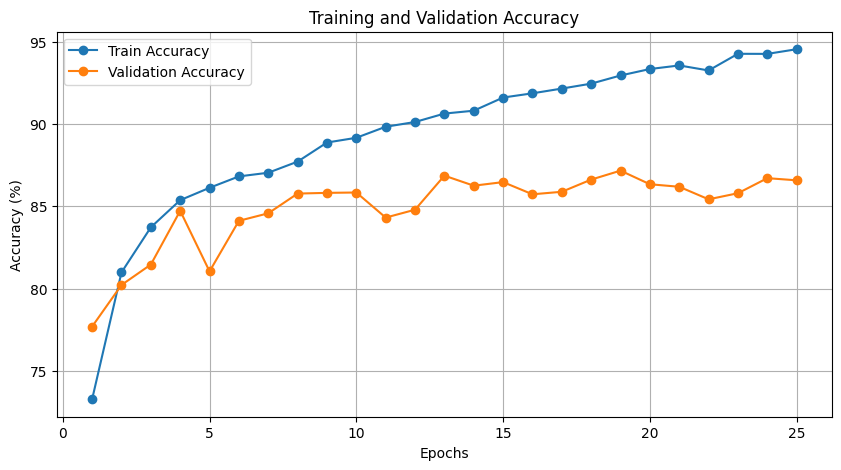

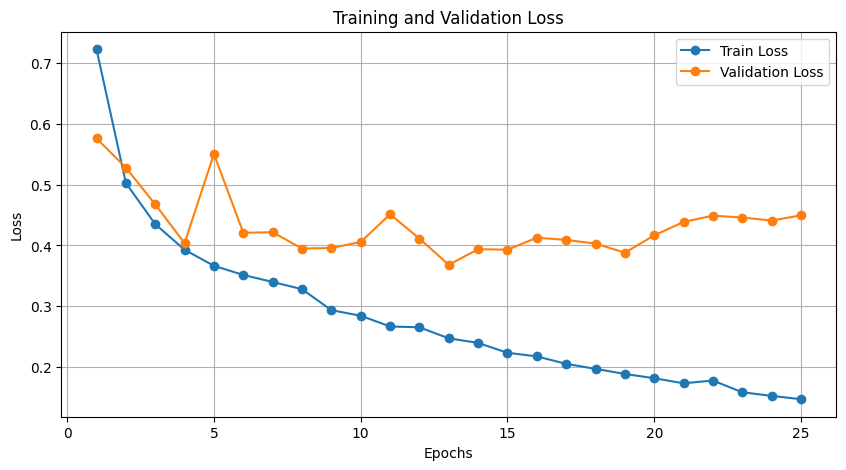

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the saved metrics
df = pd.read_csv("metrics.csv")

# Visualization for Accuracy
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(df['Epoch'], df['Val Accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Visualization for Loss
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss', marker='o')
plt.plot(df['Epoch'], df['Val Loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
'''from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_vit_model(model, dataloader, class_names=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = np.mean(all_preds == all_labels)

    print(f"\nAccuracy: {accuracy * 100:.2f}%")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted):    {recall:.4f}")
    print(f"F1 Score (weighted):  {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Load the best ViT model before evaluation
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
class_names = dataset.classes  # Uses folder names as class labels

evaluate_vit_model(model, val_loader, class_names)'''


'from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nimport numpy as np\n\ndef evaluate_vit_model(model, dataloader, class_names=None):\n    model.eval()\n    all_preds, all_labels = [], []\n\n    with torch.no_grad():\n        for images, labels in dataloader:\n            images, labels = images.to(DEVICE), labels.to(DEVICE)\n            outputs = model(images)\n            preds = torch.argmax(outputs, dim=1)\n            all_preds.extend(preds.cpu().numpy())\n            all_labels.extend(labels.cpu().numpy())\n\n    all_preds = np.array(all_preds)\n    all_labels = np.array(all_labels)\n\n    # Classification report\n    print("\nClassification Report:\n")\n    print(classification_report(all_labels, all_preds, target_names=class_names))\n\n    # Metrics\n    precision = precision_score(all_labels, all_preds, average=\'weighted\')\n    recall = recall_score(all_labels,

In [6]:
'''from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

def plot_roc_pr_curves_vit(model, dataloader, class_names):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_labels = np.hstack(all_labels)

    # Binarize labels for multiclass ROC/PR
    y_true_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))
    n_classes = len(class_names)

    # ROC Curve
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(12, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve (One-vs-Rest)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve
    precision, recall, avg_precision = dict(), dict(), dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
        avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

    plt.figure(figsize=(12, 6))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {avg_precision[i]:.2f})')
    plt.title("Precision-Recall Curve (One-vs-Rest)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_pr_curves_vit(model, val_loader, class_names)'''


'from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score\nfrom sklearn.preprocessing import label_binarize\n\ndef plot_roc_pr_curves_vit(model, dataloader, class_names):\n    model.eval()\n    all_probs = []\n    all_labels = []\n\n    with torch.no_grad():\n        for images, labels in dataloader:\n            images = images.to(DEVICE)\n            outputs = model(images)\n            probs = torch.softmax(outputs, dim=1).cpu().numpy()\n            all_probs.append(probs)\n            all_labels.append(labels.cpu().numpy())\n\n    all_probs = np.vstack(all_probs)\n    all_labels = np.hstack(all_labels)\n\n    # Binarize labels for multiclass ROC/PR\n    y_true_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))\n    n_classes = len(class_names)\n\n    # ROC Curve\n    fpr, tpr, roc_auc = dict(), dict(), dict()\n    for i in range(n_classes):\n        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])\n        roc_au

<ipython-input-7-e75eab882e70>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))



 Classification Report:

              precision    recall  f1-score   support

          AK       0.69      0.78      0.73       187
        Acne       0.96      0.99      0.97       496
         BCC       0.80      0.80      0.80       513
          DF       0.83      0.45      0.59        44
         MEL       0.86      0.82      0.84       985
          NV       0.87      0.92      0.90      1713
         SCC       0.66      0.49      0.56       114
         SEK       0.92      0.86      0.89       495
        VASC       0.87      0.80      0.83        50

    accuracy                           0.86      4597
   macro avg       0.83      0.77      0.79      4597
weighted avg       0.86      0.86      0.86      4597


 Overall Accuracy: 86.32%


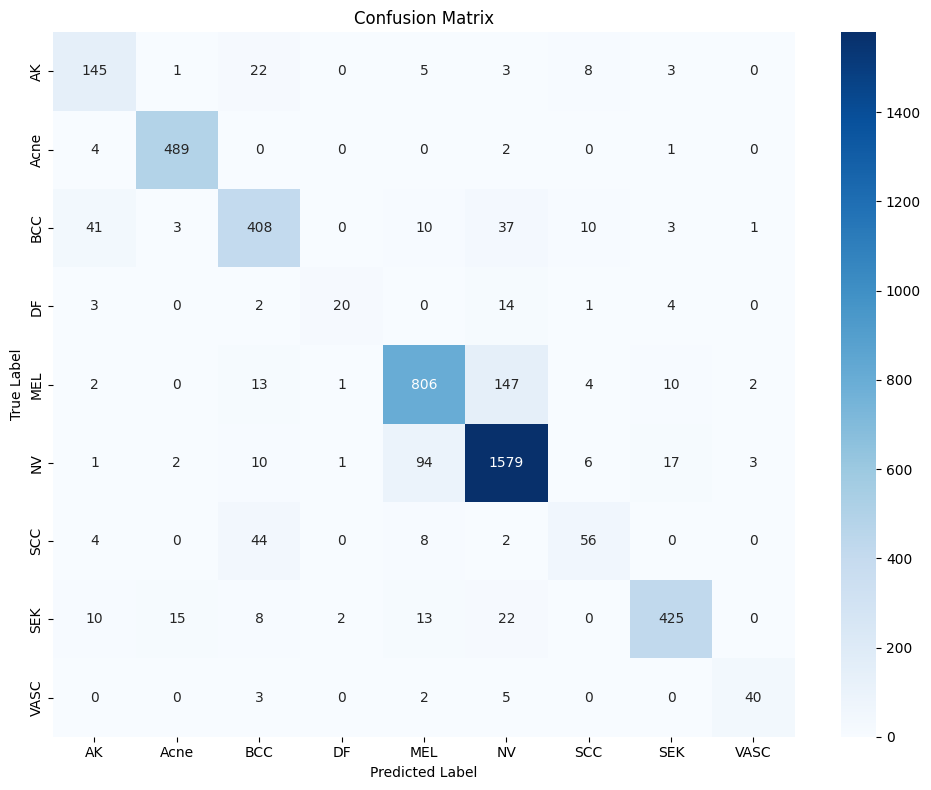

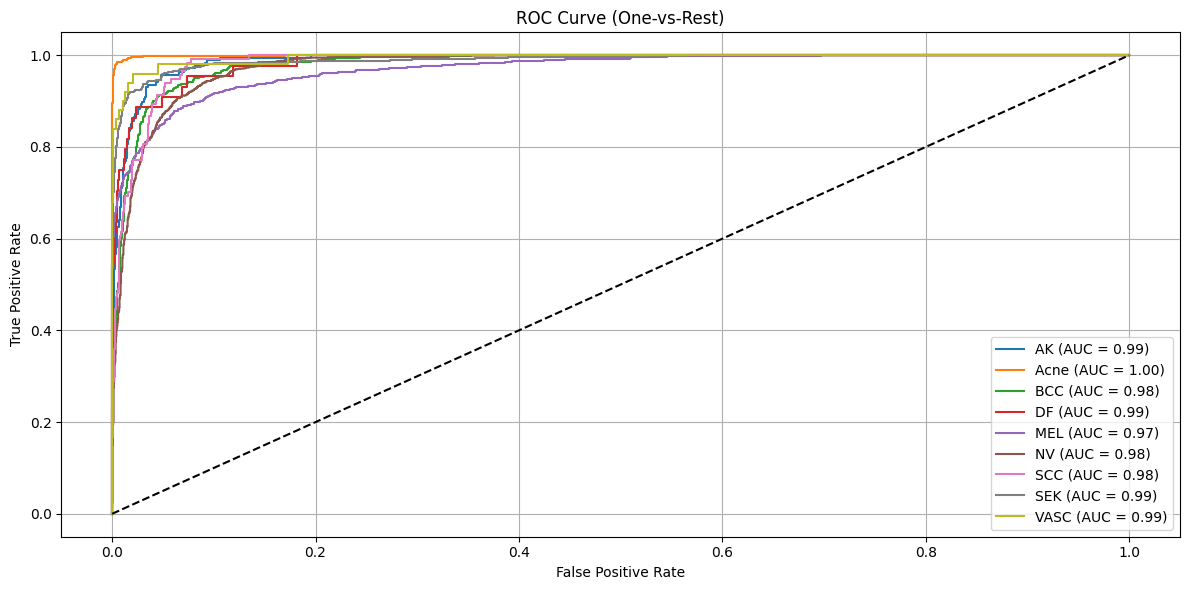

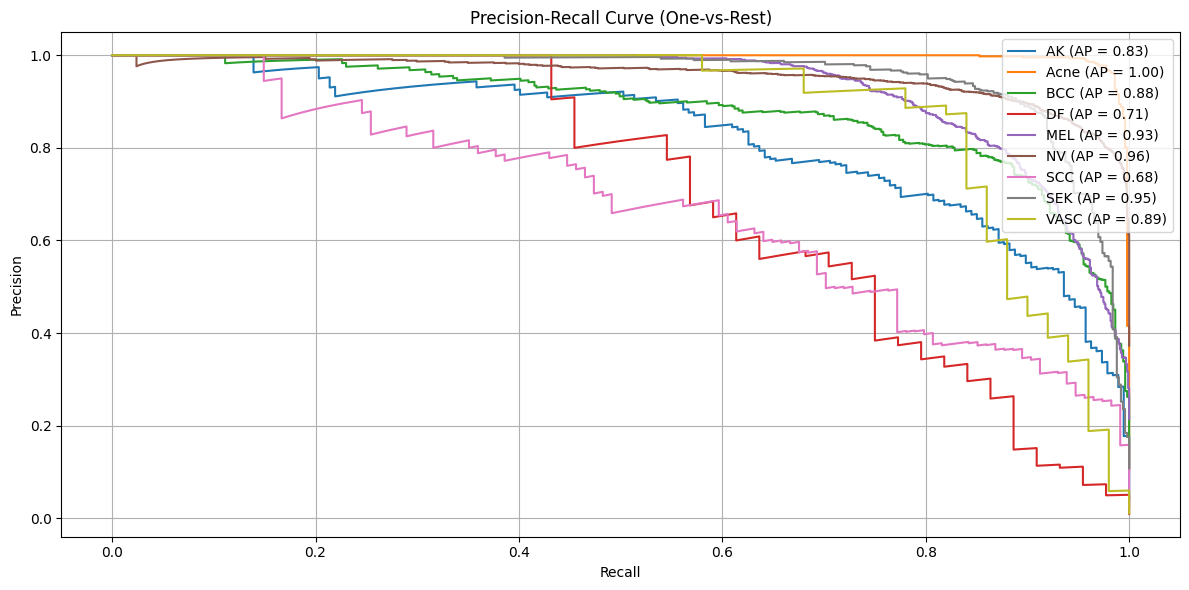

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load best saved model
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model.eval()

# Gather predictions and labels
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        
        all_probs.append(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Class names
class_names = dataset.classes

# -------------------------------
# Classification Report & Accuracy
# -------------------------------
print("\n Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

overall_accuracy = np.mean(all_preds == all_labels)
print(f"\n Overall Accuracy: {overall_accuracy * 100:.2f}%")

# -------------------------------
#  Confusion Matrix
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# -------------------------------
# ROC Curve
# -------------------------------
# Binarize labels for ROC
y_true_bin = label_binarize(all_labels, classes=np.arange(num_classes))
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Precision-Recall Curve
# -------------------------------
precision, recall, avg_precision = dict(), dict(), dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(12, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {avg_precision[i]:.2f})')
plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
